In [2]:
import os
import pickle
import random
import time
import json

import numpy as np
import pandas as pd
import xgboost as xgb
import shap

from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import f1_score, classification_report
from sklearn.model_selection  import GroupKFold
from sklearn.utils            import compute_sample_weight
from imblearn.over_sampling   import SMOTE

# ————————————————————————————————————————————————
# 1) Drop Highly Correlated Features from X_train.
def drop_correlated_features(X: pd.DataFrame, threshold: float = 0.95):
    """
    Returns (X_reduced, dropped_columns).
    Drops any feature that has |corr| ≥ threshold with any previously-kept feature.
    """
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] >= threshold)]
    X_reduced = X.drop(columns=to_drop)
    return X_reduced, to_drop

# ————————————————————————————————————————————————
# 2) SHAP‐Based Feature Selection with Safe SMOTE
def select_top_shap_features(
    X_train: pd.DataFrame,
    y_train_num: np.ndarray,
    n_top: int = 50,
    smote_ratio: float = 0.3
):
    """
    1) If minority_count < smote_ratio * majority_count, SMOTE‐oversample minority.
    2) Train a quick XGB on that (possibly oversampled) data.
    3) Compute SHAP values and return top n_top features by mean |SHAP|.
    """
    # Determine class counts
    classes, counts = np.unique(y_train_num, return_counts=True)
    maj_count = counts.max()
    min_count = counts.min()
    desired_min = int(maj_count * smote_ratio)

    if min_count < desired_min:
        sampling_strategy = {classes[np.argmin(counts)]: desired_min}
    else:
        sampling_strategy = "auto"

    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_tr_over, y_tr_over = sm.fit_resample(X_train, y_train_num)

    # Train a lightweight XGBoost
    baseline = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="aucpr",
        random_state=42
    )
    baseline.fit(X_tr_over, y_tr_over, verbose=False)

    # Compute SHAP on the oversampled data
    explainer = shap.TreeExplainer(baseline)
    shap_vals = explainer.shap_values(X_tr_over)
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    feat_importance = pd.Series(mean_abs_shap, index=X_train.columns)
    top_features = feat_importance.sort_values(ascending=False).head(n_top).index.tolist()
    return top_features

In [2]:
# ————————————————————————————————————————————————
# 3) CV Macro‐F1 with GroupKFold + SMOTE in Each Fold
def cv_macro_f1_grouped_oversample(
    params,
    X: pd.DataFrame,
    y_num: np.ndarray,
    groups: pd.Series,
    smote_ratio: float = 0.3,
    n_splits: int = 5
):
    """
    GroupKFold: no patient leaks between train/val in any fold.
    Within each fold:
      - Possibly SMOTE‐oversample the train portion to smote_ratio of majority.
      - Train XGB(**params). Predict on val, sweep thresholds in [0.01,0.99] for macro-F1.
      - Return mean of each fold’s best macro-F1.
    """
    gkf = GroupKFold(n_splits=n_splits)
    fold_scores = []
    thresh_candidates = np.arange(0.01, 1.00, 0.01)

    for tr_idx, val_idx in gkf.split(X, y_num, groups=groups):
        X_tr_f,  X_val_f  = X.iloc[tr_idx],  X.iloc[val_idx]
        y_tr_f,  y_val_f  = y_num[tr_idx],   y_num[val_idx]

        # Determine SMOTE strategy for this fold
        classes, counts = np.unique(y_tr_f, return_counts=True)
        maj_count = counts.max()
        min_count = counts.min()
        desired_min = int(maj_count * smote_ratio)

        if min_count < desired_min:
            sampling_strategy = {classes[np.argmin(counts)]: desired_min}
        else:
            sampling_strategy = "auto"

        sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
        X_tr_over, y_tr_over = sm.fit_resample(X_tr_f, y_tr_f)
        sw_tr_over = compute_sample_weight("balanced", y_tr_over)

        model = xgb.XGBClassifier(**params)
        model.fit(
            X_tr_over,
            y_tr_over,
            sample_weight = sw_tr_over,
            eval_set = [(X_val_f, y_val_f)],
            sample_weight_eval_set = [compute_sample_weight("balanced", y_val_f)],
            verbose=False
        )

        proba_val_f = model.predict_proba(X_val_f)[:, 1]

        best_fold_f1 = 0.0
        for t in thresh_candidates:
            preds_t = (proba_val_f >= t).astype(int)
            fold_f1 = f1_score(y_val_f, preds_t, average='macro')
            if fold_f1 > best_fold_f1:
                best_fold_f1 = fold_f1

        fold_scores.append(best_fold_f1)

    return np.mean(fold_scores)

# ————————————————————————————————————————————————
# 4) Main Random Search Function
def random_search_xgb_enhanced(
    X_train_full: pd.DataFrame,
    y_train_full: pd.Series,
    patients_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    patients_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    patients_test: pd.Series,
    param_space: dict,
    results_path: str,
    best_model_bin: str,
    corr_threshold: float = 0.95,
    shap_top_k: int = 50,
    smote_ratio: float = 0.3,
    n_splits: int = 5
):
    """
    1) Drop correlated features in X_train_full (corr_threshold).
    2) Encode y_train_full → numeric for SHAP.
    3) SHAP‐select top shap_top_k features (with SMOTE).
    4) Reduce X_train_full, X_val, X_test to those top features.
    5) Label‐encode train/val/test and compute val sample weights.
    6) Random‐search:
       - CV with GroupKFold+SMOTE (cv_macro_f1_grouped_oversample).
       - Final train on full SMOTE‐oversampled X_train, threshold sweep on val, eval on test.
       - Save best model and history to disk.
    """
    # Step 4.1: Drop correlated features
    print("Dropping correlated features (threshold=%.2f)..." % corr_threshold)
    X_train_no_corr, dropped_corr = drop_correlated_features(X_train_full, threshold=corr_threshold)
    print(f"Dropped {len(dropped_corr)} features:", dropped_corr, "\n")

    X_val_no_corr  = X_val[X_train_no_corr.columns]
    X_test_no_corr = X_test[X_train_no_corr.columns]

    # Step 4.2: Label‐encode y_train_full for SHAP selection
    le_shap = LabelEncoder().fit(y_train_full)
    y_train_nums = le_shap.transform(y_train_full)

    # Step 4.2a: SHAP feature selection
    print(f"Selecting top {shap_top_k} features by SHAP (with SMOTE ratio={smote_ratio})...")
    top_features = select_top_shap_features(
        X_train_no_corr, y_train_nums, n_top=shap_top_k, smote_ratio=smote_ratio
    )
    print("Top SHAP features:", top_features, "\n")

    # Subset to top_features
    X_train = X_train_no_corr[top_features].reset_index(drop=True)
    X_val   = X_val_no_corr[top_features].reset_index(drop=True)
    X_test  = X_test_no_corr[top_features].reset_index(drop=True)

    y_train = y_train_full.reset_index(drop=True)
    y_val   = y_val.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    patients_train = patients_train.reset_index(drop=True)
    patients_val   = patients_val.reset_index(drop=True)
    patients_test  = patients_test.reset_index(drop=True)

    # Step 4.3: Final LabelEncoder for train/val/test
    le = LabelEncoder().fit(y_train)
    y_tr   = le.transform(y_train)
    y_vale = le.transform(y_val)
    y_te   = le.transform(y_test)

    # Step 4.4: Sample weights for validation only (train uses SMOTE)
    sw_val = compute_sample_weight("balanced", y_vale)

    # Load or initialize history
    if os.path.exists(results_path):
        history = pickle.load(open(results_path, 'rb'))
    else:
        history = {
            'tried_params': {},
            'best': {
                'params':        None,
                'f1_val':        0.0,
                'threshold':     0.5,
                'f1_val_thresh': 0.0,
                'f1_test':       0.0,
                'model_path':    None
            }
        }

    iteration = 0
    try:
        while True:
            iteration += 1
            # Sample hyperparameters (including optional reg_alpha, reg_lambda, etc.)
            params = {
                'n_estimators':        random.randint(*param_space['n_estimators']),
                'learning_rate':       random.uniform(*param_space['learning_rate']),
                'max_depth':           random.randint(*param_space['max_depth']),
                'subsample':           random.uniform(*param_space['subsample']),
                'colsample_bytree':    random.uniform(*param_space['colsample_bytree']),
                'objective':           'binary:logistic',
                'random_state':        42,
                'eval_metric':         'aucpr',
                'early_stopping_rounds': 50,
                **({ 'reg_alpha': random.uniform(*param_space['reg_alpha']) }     if 'reg_alpha' in param_space else {}),
                **({ 'reg_lambda': random.uniform(*param_space['reg_lambda']) }   if 'reg_lambda' in param_space else {}),
                **({ 'gamma': random.uniform(*param_space['gamma']) }             if 'gamma' in param_space else {}),
                **({ 'min_child_weight': random.uniform(*param_space['min_child_weight']) } if 'min_child_weight' in param_space else {})
            }

            key = json.dumps(params, sort_keys=True)
            if key in history['tried_params']:
                continue

            # Step 4.5A: CV with GroupKFold + SMOTE inside each fold
            f1_val = cv_macro_f1_grouped_oversample(
                params,
                X_train, np.array(y_tr),
                patients_train,
                smote_ratio=smote_ratio,
                n_splits=n_splits
            )

            # Step 4.5B: Final train on full SMOTE-oversampled X_train
            classes, counts = np.unique(y_tr, return_counts=True)
            maj_count = counts.max()
            min_count = counts.min()
            desired_min = int(maj_count * smote_ratio)

            if min_count < desired_min:
                sampling_strategy = {classes[np.argmin(counts)]: desired_min}
            else:
                sampling_strategy = "auto"

            sm_final = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
            X_tr_fin, y_tr_fin = sm_final.fit_resample(X_train, np.array(y_tr))
            sw_tr_fin = compute_sample_weight("balanced", y_tr_fin)

            model = xgb.XGBClassifier(**params)
            model.fit(
                X_tr_fin, y_tr_fin,
                sample_weight = sw_tr_fin,
                eval_set = [(X_val, y_vale)],
                sample_weight_eval_set = [sw_val],
                verbose=False
            )

            # Step 4.5C: Threshold sweep on VALIDATION
            val_probs = model.predict_proba(X_val)[:, 1]
            best_thresh = 0.5
            best_f1_val_thresh = 0.0
            for t in np.arange(0.01, 1.00, 0.01):
                val_preds_t = (val_probs >= t).astype(int)
                f1_val_t = f1_score(y_vale, val_preds_t, average='macro')
                if f1_val_t > best_f1_val_thresh:
                    best_f1_val_thresh = f1_val_t
                    best_thresh = t

            # Step 4.5D: Evaluate on TEST
            test_probs = model.predict_proba(X_test)[:, 1]
            test_preds = (test_probs >= best_thresh).astype(int)
            f1_test = f1_score(y_te, test_preds, average='macro')

            # Step 4.5E: Record in history
            history['tried_params'][key] = {
                'f1_val':          f1_val,
                'threshold':       best_thresh,
                'f1_val_thresh':   best_f1_val_thresh,
                'f1_test':         f1_test,
                'time':            time.time()
            }

            # Step 4.5F: Update best if needed
            best = history['best']
            better_f1_val     = f1_val > best['f1_val']
            tie_f1_val        = np.isclose(f1_val, best['f1_val'])
            better_f1_test    = f1_test > best.get('f1_test', 0.0)
            not_worse_f1_test = f1_test >= best.get('f1_test', 0.0)

            if (better_f1_val and not_worse_f1_test) or (tie_f1_val and better_f1_test):
                history['best'] = {
                    'params':         params,
                    'f1_val':         f1_val,
                    'threshold':      best_thresh,
                    'f1_val_thresh':  best_f1_val_thresh,
                    'f1_test':        f1_test,
                    'model_path':     best_model_bin
                }
                os.makedirs(os.path.dirname(best_model_bin) or '.', exist_ok=True)
                model.save_model(best_model_bin)

                # Print classification report on TEST
                cr = classification_report(
                    y_te,
                    test_preds,
                    target_names = le.inverse_transform([0,1]),
                    digits = 4
                )
                print(f"[Iter {iteration}] 🎉 New best cv_macro_f1={f1_val:.4f}, "
                      f"val_macro_f1_at_thresh={best_f1_val_thresh:.4f}, "
                      f"test_macro_f1={f1_test:.4f}")
                print("            params =", params)
                print(f"            best threshold = {best_thresh:.2f}\n")
                print("=== Classification Report on TEST ===")
                print(cr)

            # Step 4.5G: Save history to disk
            os.makedirs(os.path.dirname(results_path) or '.', exist_ok=True)
            pickle.dump(history, open(results_path, 'wb'))

    except KeyboardInterrupt:
        # Save final history and show best so far
        pickle.dump(history, open(results_path, 'wb'))
        b = history['best']
        print("\n🔸 Interrupted — best so far:")
        print(f"   f1_val           = {b['f1_val']:.4f}")
        print(f"   threshold (val)  = {b['threshold']:.2f}")
        print(f"   f1_val_thresh    = {b['f1_val_thresh']:.4f}")
        print(f"   f1_test          = {b['f1_test']:.4f}")
        print(f"   params           = {b['params']}")
        print(f"   model            = {b['model_path']}")

In [4]:
if os.path.exists('outputs/X_train_B.pkl'):
    # Load the required datasets
    X_train_B        = pd.read_pickle('outputs/X_train_B.pkl')
    y_train_B        = pd.read_pickle('outputs/y_train_B.pkl')
    X_val_B          = pd.read_pickle('outputs/X_val_B.pkl')
    y_val_B          = pd.read_pickle('outputs/y_val_B.pkl')
    X_test_B         = pd.read_pickle('outputs/X_test_B.pkl')
    y_test_B         = pd.read_pickle('outputs/y_test_B.pkl')
    patients_train_B = pd.read_pickle('outputs/patients_train_B.pkl')
    patients_val_B   = pd.read_pickle('outputs/patients_val_B.pkl')
    patients_test_B  = pd.read_pickle('outputs/patients_test_B.pkl')
    
    print(f"Loaded datasets from pickle files:")
    print(f"  X_train_B shape: {X_train_B.shape}")
    print(f"  X_val_B   shape: {X_val_B.shape}")
    print(f"  X_test_B  shape: {X_test_B.shape}\n")
    

Loaded datasets from pickle files:
  X_train_B shape: (12023, 217)
  X_val_B   shape: (6454, 217)
  X_test_B  shape: (6505, 217)



In [ ]:
if os.path.exists('outputs/X_train_B.pkl'):
    # Load the required datasets
    X_train_B        = pd.read_pickle('outputs/X_train_B.pkl')
    y_train_B        = pd.read_pickle('outputs/y_train_B.pkl')
    X_val_B          = pd.read_pickle('outputs/X_val_B.pkl')
    y_val_B          = pd.read_pickle('outputs/y_val_B.pkl')
    X_test_B         = pd.read_pickle('outputs/X_test_B.pkl')
    y_test_B         = pd.read_pickle('outputs/y_test_B.pkl')
    patients_train_B = pd.read_pickle('outputs/patients_train_B.pkl')
    patients_val_B   = pd.read_pickle('outputs/patients_val_B.pkl')
    patients_test_B  = pd.read_pickle('outputs/patients_test_B.pkl')
    
    print(f"Loaded datasets from pickle files:")
    print(f"  X_train_B shape: {X_train_B.shape}")
    print(f"  X_val_B   shape: {X_val_B.shape}")
    print(f"  X_test_B  shape: {X_test_B.shape}\n")
    
    # Define the enhanced hyperparameter space
    PARAM_SPACE_ENHANCED = {
        'n_estimators':      (10, 30),
        'learning_rate':     (0.01, 0.3),
        'max_depth':         (1, 1),
        'subsample':         (0.7, 0.9),
        'colsample_bytree':  (0.7, 0.9),
        'reg_alpha':         (0.0, 3.0),
        'reg_lambda':        (0.0, 3.0),
        'gamma':             (0.0, 3.0),
        'min_child_weight':  (1, 10)
    }

    RESULTS_PICKLE = "outputs/xgb_enhanced_search_B.pkl"
    BEST_MODEL_BIN = "outputs/xgb_enhanced_best_model_B.ubj"

    # Invoke the enhanced random search
    random_search_xgb_enhanced(
        X_train_full   = X_train_B,
        y_train_full   = y_train_B,
        patients_train = patients_train_B,
        X_val          = X_val_B,
        y_val          = y_val_B,
        patients_val   = patients_val_B,
        X_test         = X_test_B,
        y_test         = y_test_B,
        patients_test  = patients_test_B,
        param_space    = PARAM_SPACE_ENHANCED,
        results_path   = RESULTS_PICKLE,
        best_model_bin = BEST_MODEL_BIN,
        corr_threshold = 0.95,      # drop features with |corr| ≥ 0.95
        shap_top_k     = 50,        # keep top 50 features by SHAP
        smote_ratio    = 0.3,       # oversample minority to 30% of majority
        n_splits       = 5
    )
else:
    print("Error: Dataset files not found in 'outputs/' directory.")
    print("Please ensure you have saved the splits via to_pickle first.")

Loaded datasets from pickle files:
  X_train_B shape: (12023, 217)
  X_val_B   shape: (6454, 217)
  X_test_B  shape: (6505, 217)

Dropping correlated features (threshold=0.95)...
Dropped 0 features: [] 

Selecting top 50 features by SHAP (with SMOTE ratio=0.3)...
Top SHAP features: ['BMI', 'ecg_feature_3', 'Age', 'Height', 'DLP', 'PVC_transition_V4', 'Weight', 'PVC_transition_V3', 'PVC_transition_V1', 'PVC_transition_V5', 'Sex', 'ecg_feature_1', 'ecg_feature_2', 'ecg_feature_12', 'HTA', 'PVC_transition_V2', 'ecg_feature_27', 'Sleep_apnea', 'ecg_feature_6', 'ecg_feature_15', 'PVC_transition_V6', 'DM', 'ecg_feature_31', 'ecg_feature_22', 'ecg_feature_42', 'Smoker', 'ecg_feature_47', 'ecg_feature_40', 'ecg_feature_32', 'ecg_feature_14', 'ecg_feature_4', 'ecg_feature_8', 'ecg_feature_23', 'ecg_feature_38', 'ecg_feature_69', 'ecg_feature_74', 'ecg_feature_48', 'ecg_feature_70', 'ecg_feature_44', 'ecg_feature_52', 'COPD', 'ecg_feature_26', 'ecg_feature_11', 'ecg_feature_13', 'ecg_feature_5',

Exception ignored in: <function DMatrix.__del__ at 0x168bf59d0>
Traceback (most recent call last):
  File "/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py", line 932, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
KeyboardInterrupt: 



→ Selected threshold = 0.79  (Val MACRO-F1 = 0.7246)

=== Validation @ threshold 0.79 ===
  Macro Accuracy : 0.8506
  Macro Precision: 0.6962
  Macro Recall   : 0.7821
  Macro F1-Score : 0.7246
  ROC AUC        : 0.8700
  PR AUC         : 0.9809

Classification Report (per class):
              precision    recall  f1-score   support

        LVOT     0.4411    0.6904    0.5383       814
        RVOT     0.9514    0.8738    0.9109      5640

    accuracy                         0.8506      6454
   macro avg     0.6962    0.7821    0.7246      6454
weighted avg     0.8870    0.8506    0.8639      6454

------------------------------------------------------------

=== Test @ threshold 0.79 ===
  Macro Accuracy : 0.8387
  Macro Precision: 0.7706
  Macro Recall   : 0.7801
  Macro F1-Score : 0.7751
  ROC AUC        : 0.8552
  PR AUC         : 0.9565

Classification Report (per class):
              precision    recall  f1-score   support

        LVOT     0.6397    0.6721    0.6555      14

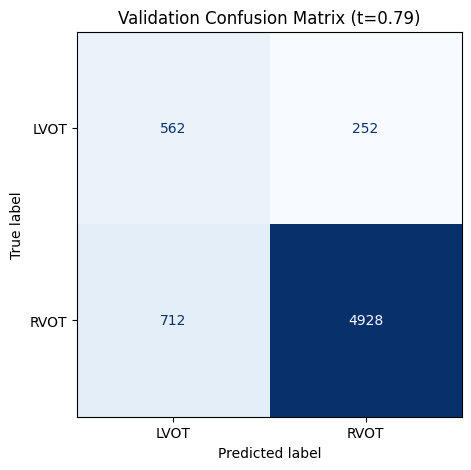

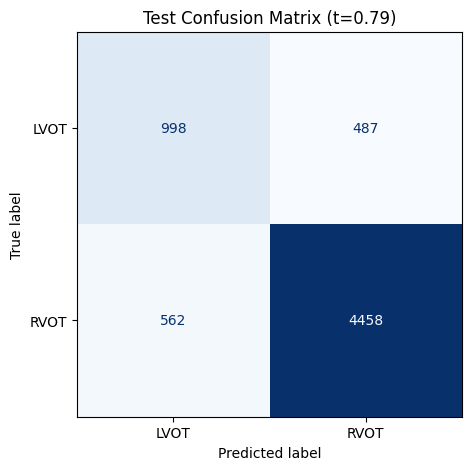

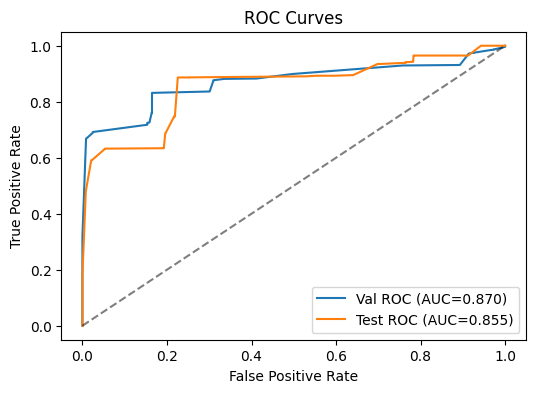

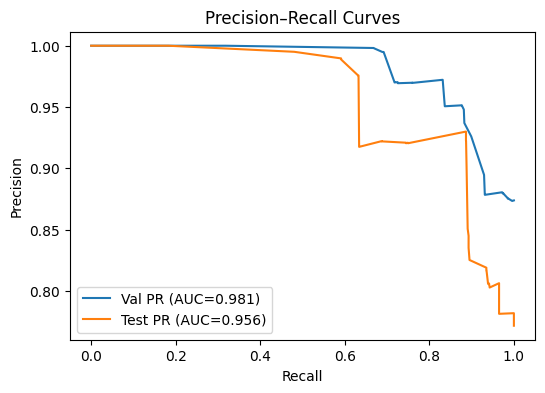

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing      import LabelEncoder
from sklearn.metrics            import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.calibration        import CalibratedClassifierCV

def evaluate_with_auto_threshold(
    model,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    calibrate: bool = False,
    calibrator_method: str = 'sigmoid'
):
    """
    1) Fit LabelEncoder on y_train.
    2) Retrieve feature names from `model` and subset X_val, X_test accordingly.
    3) (Optional) Calibrate on (X_val_sub, y_val_enc).
    4) Sweep threshold on val to maximize macro-F1.
    5) Print metrics & classification reports for Val & Test.
    6) Show ROC, PR curves, confusion matrices.
    """
    # STEP 1: Fit LabelEncoder on y_train
    le = LabelEncoder().fit(y_train)
    y_val_enc  = le.transform(y_val)
    y_test_enc = le.transform(y_test)

    # STEP 2: Get feature names from trained booster
    feature_list = model.get_booster().feature_names
    X_val_sub  = X_val[feature_list]
    X_test_sub = X_test[feature_list]

    # STEP 3: (Optional) Calibrate on VAL
    if calibrate:
        calibrator = CalibratedClassifierCV(
            estimator=model, method=calibrator_method, cv='prefit'
        )
        calibrator.fit(X_val_sub, y_val_enc)
        proba_val  = calibrator.predict_proba(X_val_sub)[:, 1]
        proba_test = calibrator.predict_proba(X_test_sub)[:, 1]
    else:
        proba_val  = model.predict_proba(X_val_sub)[:, 1]
        proba_test = model.predict_proba(X_test_sub)[:, 1]

    # STEP 4: Threshold sweep on VAL
    thresholds = np.linspace(0.01, 0.99, 99)
    best_macro_f1  = -1.0
    best_threshold = 0.50

    for t in thresholds:
        preds_val_t = (proba_val >= t).astype(int)
        macro_f1_val_t = f1_score(y_val_enc, preds_val_t, average='macro')
        if macro_f1_val_t > best_macro_f1:
            best_macro_f1  = macro_f1_val_t
            best_threshold = t

    print(f"\n→ Selected threshold = {best_threshold:.2f}  (Val MACRO-F1 = {best_macro_f1:.4f})\n")

    # STEP 5: Print metrics & classification reports
    def print_metrics_and_report(y_true_enc, proba, split_name):
        y_pred = (proba >= best_threshold).astype(int)

        acc     = accuracy_score(y_true_enc, y_pred)
        prec    = precision_score(y_true_enc, y_pred, average='macro')
        rec     = recall_score(y_true_enc, y_pred, average='macro')
        f1m     = f1_score(y_true_enc, y_pred, average='macro')
        rocauc  = roc_auc_score(y_true_enc, proba)
        pr_auc  = auc(*precision_recall_curve(y_true_enc, proba)[:2][::-1])

        print(f"=== {split_name} @ threshold {best_threshold:.2f} ===")
        print(f"  Macro Accuracy : {acc:.4f}")
        print(f"  Macro Precision: {prec:.4f}")
        print(f"  Macro Recall   : {rec:.4f}")
        print(f"  Macro F1-Score : {f1m:.4f}")
        print(f"  ROC AUC        : {rocauc:.4f}")
        print(f"  PR AUC         : {pr_auc:.4f}\n")

        print("Classification Report (per class):")
        print(classification_report(
            le.inverse_transform(y_true_enc),
            le.inverse_transform(y_pred),
            target_names = list(le.classes_),
            digits = 4
        ))
        print("-" * 60 + "\n")

    print_metrics_and_report(y_val_enc, proba_val, "Validation")
    print_metrics_and_report(y_test_enc, proba_test, "Test")

    # STEP 6: Plots
    # 6.1 Confusion Matrices
    for proba, y_true_enc, split_name in [
        (proba_val,  y_val_enc,  "Validation"),
        (proba_test, y_test_enc, "Test")
    ]:
        y_pred = (proba >= best_threshold).astype(int)
        cm = confusion_matrix(
            le.inverse_transform(y_true_enc),
            le.inverse_transform(y_pred),
            labels = list(le.classes_)
        )
        disp = ConfusionMatrixDisplay(cm, display_labels = list(le.classes_))
        plt.figure(figsize=(5, 5))
        disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
        plt.title(f"{split_name} Confusion Matrix (t={best_threshold:.2f})")
        plt.show()

    # 6.2 ROC Curves
    fpr_v, tpr_v, _ = roc_curve(y_val_enc,  proba_val)
    fpr_t, tpr_t, _ = roc_curve(y_test_enc, proba_test)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr_v, tpr_v, label=f"Val ROC (AUC={roc_auc_score(y_val_enc, proba_val):.3f})")
    plt.plot(fpr_t, tpr_t, label=f"Test ROC (AUC={roc_auc_score(y_test_enc, proba_test):.3f})")
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc='lower right')
    plt.show()

    # 6.3 Precision–Recall Curves
    prec_v, rec_v, _ = precision_recall_curve(y_val_enc,  proba_val)
    prec_t, rec_t, _ = precision_recall_curve(y_test_enc, proba_test)
    plt.figure(figsize=(6, 4))
    plt.plot(rec_v, prec_v, label=f"Val PR (AUC={auc(rec_v, prec_v):.3f})")
    plt.plot(rec_t, prec_t, label=f"Test PR (AUC={auc(rec_t, prec_t):.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves")
    plt.legend(loc='lower left')
    plt.show()



best_model = xgb.XGBClassifier()
best_model.load_model("outputs/xgb_enhanced_best_model_B.ubj")

evaluate_with_auto_threshold(
    best_model,
    X_train_B, y_train_B,
    X_val_B,   y_val_B,
    X_test_B,  y_test_B,
    calibrate=True
)